In [2]:
import os
from datetime import datetime, timedelta
from glob import glob

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray
from dask.distributed import Client
from tqdm import tqdm

In [3]:
client = Client(n_workers=12)

In [4]:
hres = xarray.open_zarr(
    "/scratch/snx3000/acarpent/EumetsatData/SEVIRI_WGS_2016-2022_RSS.zarr"
).drop_duplicates(dim='time')
hres = hres.rename_dims({"x": "lon", "y": "lat"}).rename_vars({"x": "lon", "y": "lat"})
hres

<xarray.Dataset>
Dimensions:      (time: 222098, lat: 658, lon: 736)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 ... 2022-12-31T23:45:00
  * lon          (lon) float64 -7.775 -7.725 -7.675 -7.625 ... 28.88 28.93 28.98
  * lat          (lat) float64 28.98 29.03 29.08 29.12 ... 61.73 61.78 61.83
Data variables:
    IR_016       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_039       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_087       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_097       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_108       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_120       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_134       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS006       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS008       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_062       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_073       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    spatial_ref  int64 ...

In [5]:
lat = hres.lat.copy()
lon = hres.lon.copy()
# del hres


def clean_reindex_sarah3(df):
    df = df.sel(time=df.record_status == 0).drop_vars(
        ["record_status", "lat_bnds", "lon_bnds"]
    )
    return df.reindex(lat=lat, lon=lon, method="nearest")

In [ ]:
fns = glob("/scratch/snx3000/kschuurm/DATA/SARAH3/SID/SIDin*.nc")

sid = xarray.open_mfdataset(
    fns,
    parallel=True,
    engine="h5netcdf",
    chunks={"time": 48, "lat": -1, "lon": -1},
)
# preprocess=clean_reindex_sarah3)
sid

In [ ]:
sid = clean_reindex_sarah3(sid).chunk({"time": 48, "lat": -1, "lon": -1})

In [ ]:
a = sid.SID.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")
del a, sid

In [ ]:
fns = glob("/scratch/snx3000/kschuurm/DATA/SARAH3/SIS/SISin*.nc")

sis = xarray.open_mfdataset(
    fns,
    parallel=True,
    engine="h5netcdf",
    chunks={"time": 48, "lat": -1, "lon": -1},
)

In [ ]:
sis = clean_reindex_sarah3(sis).chunk({"time": 48, "lat": -1, "lon": -1})

In [ ]:
a = sis.SIS.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")
del a, sis

In [ ]:
fns = glob("/scratch/snx3000/kschuurm/DATA/SARAH3/CAL/CALin*.nc")

cal = xarray.open_mfdataset(
    fns,
    parallel=True,
    engine="h5netcdf",
    chunks={"time": 48, "lat": -1, "lon": -1},
)
cal

In [ ]:
cal = clean_reindex_sarah3(cal).chunk({"time": 48, "lat": -1, "lon": -1})

In [ ]:
a = cal.CAL.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")
del a, cal

In [6]:
SARAH = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr")

In [15]:
import dask
def cal_to_ki(x):
    first_cond = (x<=-0.05)
    second_cond = (x>-0.05) & (x<=0.8)
    third_cond = (x>0.8) & (x<=1.05)
    fourth_cond = (x>1.05) & (x<1.2)
    fifth_cond = (x==1.2)
    
    y=dask.array.zeros(shape=x.shape)
    
    def func1(x):
        return 1 - x
    def func2(x):
        return 1.1661 - 1.781*x + 0.73*x**2
    
    funcs = [1.05, func1, func2, 0.09, 0]
    conds = [first_cond, second_cond, third_cond, fourth_cond, fifth_cond]
    
    # y[first_cond] = 1.05
    # y[second_cond] = 1 - x[second_cond]
    # y[third_cond] = 1.1661 - 1.781*x[third_cond] + 0.73*x[third_cond]**2
    # y[fourth_cond] = 0.09
    # y[fifth_cond] = 0
    return dask.array.piecewise(x, conds, funcs)

def cal_to_ki2(x):
    y=np.nan
    if x<= -0.05:
        y= 1.05
    elif x>-.05 & x<=0.8:
        y= 1- x
    elif x>.8 & x<=1.05:
        y= 1.1661 - 1.781*x + 0.73*x**2
    elif x>1.05 & x<1.2:
        y=.09
    elif x==1.2:
        y=0
    return y

In [24]:
ki = xarray.apply_ufunc(cal_to_ki, SARAH.CAL, dask='allowed')

In [25]:
ki = ki.rename('KI')

In [27]:
ki = ki.assign_attrs(SARAH.CAL.attrs)
ki.attrs['long_name'] = 'Clear Sky Index'

In [29]:
ki.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")

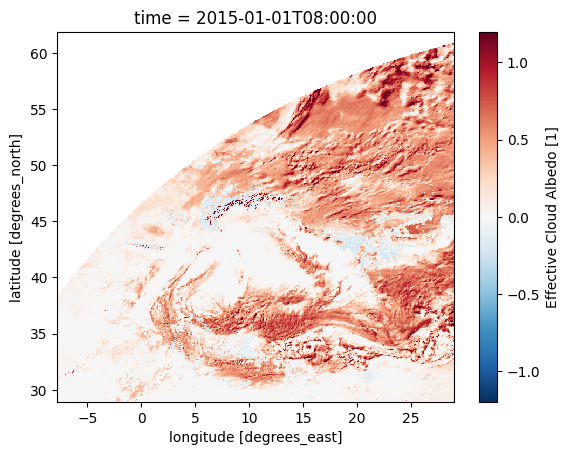

In [19]:
SARAH.CAL.isel(time=16).plot.imshow()

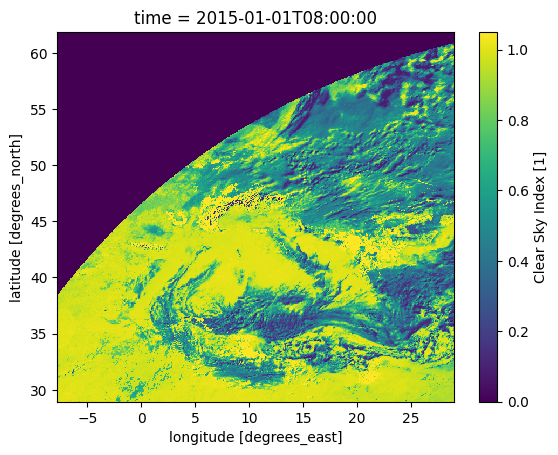

In [31]:
ki.isel(time=16).plot.imshow()